<h1> 1.1. Importing libraries </h1>

In [1]:
import shutil
import random
import os, cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from pathlib import Path
from sklearn import metrics
from tensorflow import keras
import matplotlib.pyplot as plt

from keras.regularizers import l2
from sklearn.model_selection import train_test_split

2025-07-04 15:25:36.407718: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751642736.616025      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751642736.673919      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


<h1> 1.2. Defining Constants </h1>

In [2]:
# Dataset

DATASET_PATH = "/kaggle/input/buldm-images/Buldm_combined/Buldm"
DATASET = sorted(os.listdir(DATASET_PATH))

# Image Shape

IMAGE_SIZE = 224
COLOR_CHANNELS = 3
IMAGE_SHAPE = (IMAGE_SIZE, IMAGE_SIZE, COLOR_CHANNELS)

# Classes

NUM_CLASSES = 5
CLASSES = ['handbag', 'id', 'keys', 'phone', 'wallet']

# Model Parameters

POOLING_TYPE = 'max'
NUM_EPOCHS = 100
BATCH_SIZE = 32

# Callbacks

EARLY_STOPPING = keras.callbacks.EarlyStopping(

    monitor = 'val_loss',
    patience = 10,
    restore_best_weights = True,
    
)

REDUCE_LR = keras.callbacks.ReduceLROnPlateau(

    monitor = 'val_loss',
    patience = 4,
    factor = 0.5,
    min_lr = 1e-7,
    
)

<h1> 1.3. Loading Data </h1>

In [3]:
def load_data():

    image_paths, labels = [], []

    for label, folder_name in enumerate(DATASET):

        folder_path = os.path.join(DATASET_PATH, folder_name)
        folder = os.listdir(folder_path)

        for image_name in folder:

            image_path = os.path.join(folder_path, image_name)
            
            image_paths.append(image_path)
            labels.append(label)

    return image_paths, labels

In [4]:
# 75% train, 20% validation, 5% test

image_paths, labels = load_data()

X_train, X_temp, y_train, y_temp = train_test_split(

    image_paths,
    labels,
    test_size = 0.25,
    stratify = labels,
    random_state = 42
    
)

X_val, X_test, y_val, y_test = train_test_split(

    X_temp,
    y_temp,
    test_size = 0.2,
    stratify = y_temp,
    random_state = 42
    
)

<h1> 1.4. Preprocessing Data </h1>

In [5]:
def preprocess(path, label):

  image = tf.io.read_file(path)
  image = tf.io.decode_jpeg(image, channels = 3)
  image = tf.image.resize(image, [IMAGE_SIZE, IMAGE_SIZE])
  image = keras.applications.resnet.preprocess_input(image)

  return image, label

In [6]:
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_ds = train_ds.map(preprocess).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
val_ds = val_ds.map(preprocess).batch(BATCH_SIZE * 2).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1751642749.811879      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1751642749.812653      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


<h1> 2.1. Dataset shapes </h1>

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


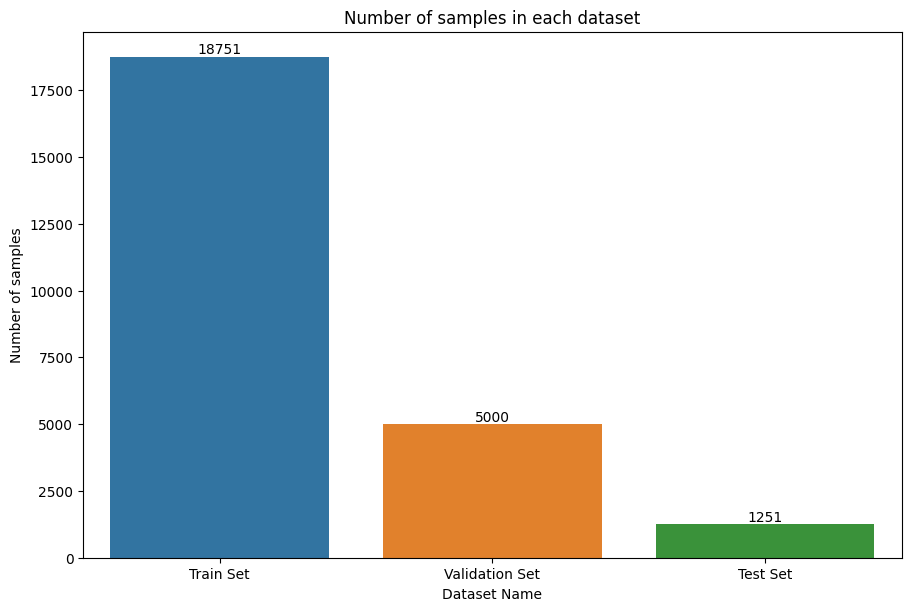

In [7]:
dataset_names = ['Train Set', 'Validation Set', 'Test Set']

dataset_shapes = [len(X_train), len(X_val), len(X_test)]
dataset_shapes = np.array(dataset_shapes, dtype = 'int32')

plt.figure(figsize = (9, 6), constrained_layout = True)

ax = sns.barplot(x = dataset_names, y = dataset_shapes)
ax.bar_label(ax.containers[0])

plt.xlabel('Dataset Name')
plt.ylabel('Number of samples')
plt.title('Number of samples in each dataset')

plt.show()

<h1> 2.2. Class Distribution </h1>

In [8]:
class_samples = pd.Series(labels).value_counts().sort_index()
print(class_samples)

0    5000
1    5003
2    5000
3    5000
4    4999
Name: count, dtype: int64


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


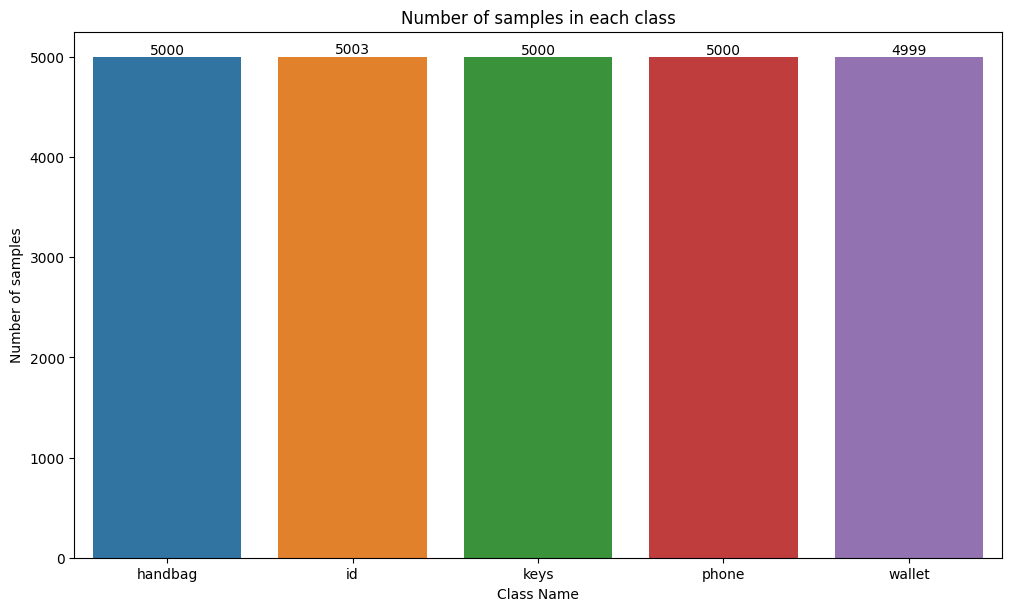

In [9]:
plt.figure(figsize = (10, 6), constrained_layout = True)

ax = sns.barplot(x = CLASSES, y = class_samples)
ax.bar_label(ax.containers[0])

plt.xlabel('Class Name')
plt.ylabel('Number of samples')
plt.title('Number of samples in each class')

plt.show()

<h1> 2.3. Class distribution using Pie Chart </h1>

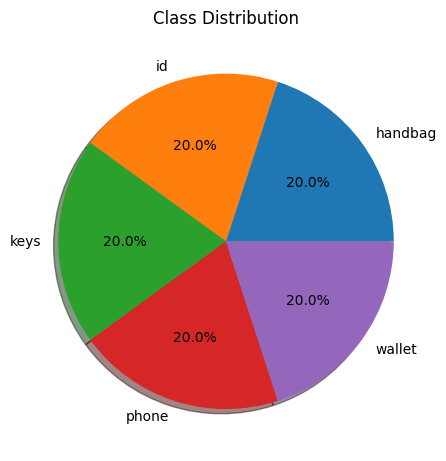

In [10]:
plt.figure(figsize = (6.5, 4.5), constrained_layout = True)

plt.pie(class_samples, labels = CLASSES, autopct = '%1.1f%%',
        pctdistance = 0.6, shadow = True)

plt.title('Class Distribution')
plt.show()

<h1> 3. Model </h1>

<h1> 3.1. Defining the model </h1>

In [12]:
# Using the pre-trained ResNet model

base_model = keras.applications.ResNet50(

    include_top = False,
    weights = 'imagenet',
    pooling = POOLING_TYPE,
    input_shape = IMAGE_SHAPE
    
)

base_model.trainable = False

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [13]:
base_model.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,587,712 (89.98 MB)

In [14]:
model = keras.models.Sequential([

    base_model,
    keras.layers.Dense(128, activation = 'relu', kernel_regularizer = l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(64, activation = 'relu', kernel_regularizer = l2(0.01)),
    keras.layers.Dropout(0.3),
    keras.layers.Dense(NUM_CLASSES, activation = 'softmax')
    
])

model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

<h1> 3.2. Training the model </h1>

In [15]:
history = model.fit(
    
    train_ds,
    epochs = NUM_EPOCHS,
    validation_data = (val_ds),
    callbacks = [EARLY_STOPPING, REDUCE_LR]
    
)

Epoch 1/100


I0000 00:00:1751642765.950925      62 service.cc:148] XLA service 0x7d3120050a10 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1751642765.951577      62 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1751642765.951598      62 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1751642767.519995      62 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/586 ━━━━━━━━━━━━━━━━━━━━ 2:47:04 17s/step - accuracy: 0.1562 - loss: 21.1478

I0000 00:00:1751642773.098779      62 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


586/586 ━━━━━━━━━━━━━━━━━━━━ 96s 135ms/step - accuracy: 0.7362 - loss: 3.8856 - val_accuracy: 0.9538 - val_loss: 1.1325 - learning_rate: 0.0010
Epoch 2/100
586/586 ━━━━━━━━━━━━━━━━━━━━ 68s 117ms/step - accuracy: 0.9245 - loss: 1.0213 - val_accuracy: 0.9546 - val_loss: 0.5334 - learning_rate: 0.0010
Epoch 3/100
586/586 ━━━━━━━━━━━━━━━━━━━━ 67s 115ms/step - accuracy: 0.9411 - loss: 0.5173 - val_accuracy: 0.9642 - val_loss: 0.3346 - learning_rate: 0.0010
Epoch 4/100
586/586 ━━━━━━━━━━━━━━━━━━━━ 83s 117ms/step - accuracy: 0.9214 - loss: 0.4377 - val_accuracy: 0.9742 - val_loss: 0.2497 - learning_rate: 0.0010
Epoch 5/100
586/586 ━━━━━━━━━━━━━━━━━━━━ 67s 115ms/step - accuracy: 0.9299 - loss: 0.3737 - val_accuracy: 0.9710 - val_loss: 0.2451 - learning_rate: 0.0010
Epoch 6/100
586/586 ━━━━━━━━━━━━━━━━━━━━ 67s 114ms/step - accuracy: 0.9283 - loss: 0.3455 - val_accuracy: 0.9748 - val_loss: 0.2010 - learning_rate: 0.0010
Epoch 7/100
586/586 ━━━━━━━━━━━━━━━━━━━━ 67s 115ms/step - accuracy: 0.9382 -

<h1> 3.3. Exporting Model Architecture and Weights </h1>

In [16]:
model.save('/kaggle/working/resnet50_custom.h5')

<h1> 4. Model Evaluation </h1>

<h1> 4.1. Training and Validation Accuracy </h1>

In [17]:
train_accuracies = history.history['accuracy']
val_accuracies = history.history['val_accuracy']

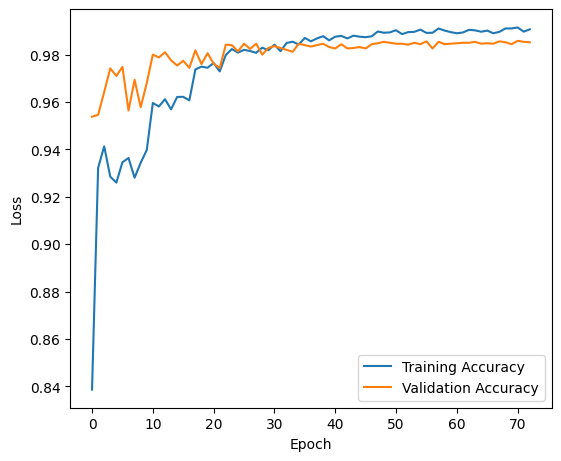

In [18]:
plt.figure(figsize = (5.5, 4.5), constrained_layout = True)

plt.plot(train_accuracies, label = 'Training Accuracy')
plt.plot(val_accuracies, label = 'Validation Accuracy')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()

In [19]:
print(f'Train Accuracy: {round(train_accuracies[-1], 2) * 100}%')
print(f'Validation Accuracy: {round(val_accuracies[-1], 2) * 100}%')

Train Accuracy: 99.0%
Validation Accuracy: 99.0%


<h1> 4.2. Training and Validation Loss </h1>

In [20]:
train_losses = history.history['loss']
val_losses = history.history['val_loss']

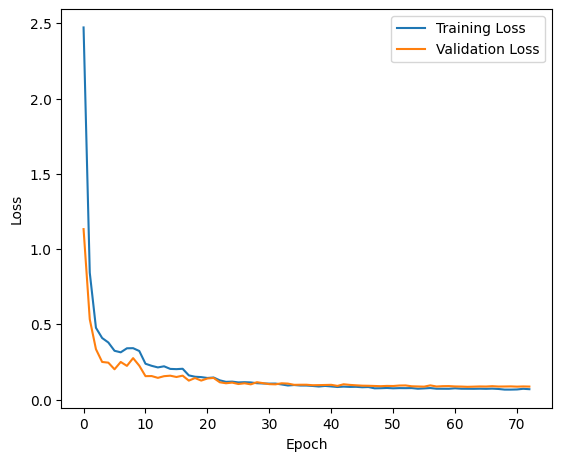

In [21]:
plt.figure(figsize = (5.5, 4.5), constrained_layout = True)

plt.plot(train_losses, label = 'Training Loss')
plt.plot(val_losses, label = 'Validation Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.legend()
plt.show()

In [22]:
print(f'train Losses: {round(train_losses[-1], 2) * 100}%')
print(f'Validation Losses: {round(val_losses[-1], 2) * 100}%')

train Losses: 7.000000000000001%
Validation Losses: 9.0%


<h1> 4.3. Getting Predicted labels </h1>

In [23]:
y_val = np.concatenate([labels for imgs, labels in val_ds])

prob_arrays = model.predict(val_ds)
y_pred = [prob_arr.argmax() for prob_arr in prob_arrays]

print("Validation labels shape:", len(y_val))
print("Predict labels shape:", len(y_pred))

79/79 ━━━━━━━━━━━━━━━━━━━━ 23s 231ms/step
Validation labels shape: 5000
Predict labels shape: 5000


<h1> 4.4. Confusion Matrix </h1>

<Axes: >

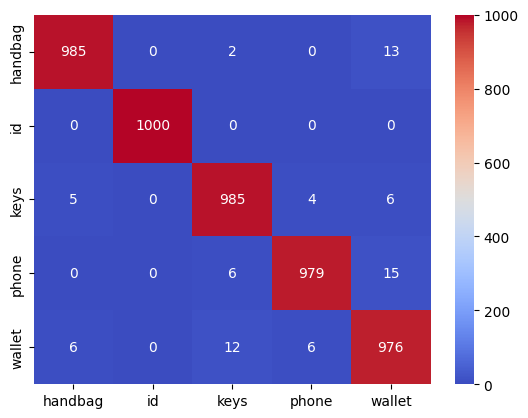

In [24]:
cm = metrics.confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot = True, fmt = '.0f', cmap = 'coolwarm', xticklabels = CLASSES, yticklabels = CLASSES)

<h1> 4.5. Classifcation Report </h1>

In [25]:
report = metrics.classification_report(y_val, y_pred, target_names = CLASSES)
print(report)

              precision    recall  f1-score   support

     handbag       0.99      0.98      0.99      1000
          id       1.00      1.00      1.00      1000
        keys       0.98      0.98      0.98      1000
       phone       0.99      0.98      0.98      1000
      wallet       0.97      0.98      0.97      1000

    accuracy                           0.98      5000
   macro avg       0.99      0.98      0.99      5000
weighted avg       0.99      0.98      0.99      5000



In [26]:
# Average Precision, Recall and F1 Scores

precision = metrics.precision_score(y_pred, y_val, average = 'weighted')
recall = metrics.recall_score(y_pred, y_val, average = 'weighted')
f1_score = metrics.f1_score(y_pred, y_val, average = 'weighted')

print(f'Precision Score = {round(precision, 2) * 100}%')
print(f'Recall Score = {round(recall, 2) * 100}%')
print(f'F1 Score = {round(f1_score, 2) * 100}%')

Precision Score = 98.0%
Recall Score = 98.0%
F1 Score = 98.0%
